<a href="https://colab.research.google.com/github/yagohilario1992/Data_Science/blob/main/Detec%C3%A7%C3%A3o_de_Fraude_em_Cart%C3%B5es_de_Cr%C3%A9dito.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

---
<img alt="Colaboratory logo" width="15%" src="https://raw.githubusercontent.com/yagohilario1992/Data_Science/main/Yago%20Hil%C3%A1rio%20Andrade.png">

#### [**Yago Hilário Andrade**](https://www.linkedin.com/in/yago-hilario/)

---

# Detecção de Fraudes em Cartões de Crédito
### Contextualização
Neste projeto, iremos abordar o problema das fraudes em cartões de crédito, uma das principais preocupações das instituições financeiras como bancos e *fintechs*. Apenas no Brasil, cerca de 12,1 milhões de pessoas já foram vítimas de algum tipo de fraude financeira em 2019. Traduzindo em valores, os golpes financeiros ultrapassaram a cifra de R$ 1,8 bilhão de prejuízo por ano para os últimos 12 meses.

Dentre essas fraudes, aquelas envolvendo cartões de crédito são de grande relevância uma vez que a sua não-detecção acaretará em prejuízos consideráveis, tanto para o consumidor quanto para a instituição financeira.

Um outro fator a ser considerado é a quantidade de falsos positivos, ou seja, aquelas vezes em que você tentou fazer uma compra e teve seu cartão bloqueado preventivamente - o que provavelmente gerou estresse e constrangimento.

Por todos esses motivos, o investimento na área de detecção de fraudes por meio de Inteligência Artificial vem crescendo a cada ano, representando uma grande oportunidade em *Data Science*. 

Dispondo de grandes volumes de dados como base histórica, um algoritmo de machine learning apenas um pouco melhor que os anteriores já representa uma economia de milhões de Reais. E esse é o desafio, aprimorar cada vez mais o uso de algoritmos visando inibir ou evitar transações fraudulentas.

## Importando os Dados

Os dados que usaremos neste projeto foram disponibilizados por algumas empresas européias de cartão de crédito. O *dataset* representa as operações financeiras que aconteceram no período de dois dias, onde foram classificadas 492 fraudes em meio a quase 290 mil transações.

Como você pode notar, este é um conjunto de dados extremamente desbalanceado, onde as fraudes representam apenas 0,17% do total.

Outro detalhe interessante é que as *features* são todas numéricas, e foram descaracterizadas (por problemas ligados à privacidade e segurança). Assim, os nomes das colunas são representados por $[V1, V2, V3 \dots, V28]$ 


[Na página original dos dados](https://www.kaggle.com/mlg-ulb/creditcardfraud), também é informado que as variáveis passaram por uma transformação conhecida como Análise de Componentes Principais (*Principal Component Analysis* - PCA).

A PCA permite a redução da dimensionalidade enquanto mantém o maior número possível de informações. Para conseguir isso, o algoritmo encontra um conjunto novo de recursos - os chamados **componentes**.

Esses componentes são em número menor or igual às variáveis originais. No caso deste projeto, os componentes achados pela transformação da PCA são as próprias colunas $[V1, V2, V3 \dots, V28]$.

In [1]:
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)

!pip install -q scikit-plot

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scikitplot as skplt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score

from imblearn.under_sampling import RandomUnderSampler

sns.set_style('dark')

In [3]:
file_path = "https://www.dropbox.com/s/b44o3t3ehmnx2b7/creditcard.csv?dl=1"

df = pd.read_csv(file_path)

Por se tratar de um *dataset* pré processado, não é necessaria nenhum ajuste nessa etapa, podendo assim, seguir para a fase da análize exploratória.

# Análise Exploratória

A análise exploratória é o "pontapé" inicial de todo projeto de data science, a partir dele começamos a se ter ideia da complexidade e das melhores tecnicas vamos utilizar para obter o resultados satisfatórios.

### Visualizando Entradas

In [4]:
#Primeiras entradas
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


Como informado anteriormente os dados passaram por uma transformação conhecida como Análise de Componentes Principais (Principal Component Analysis - PCA), afim de reduzir as dimesões dos dados analizados e assegurar a privacidade dos usuários.

### Resumo Estatístico

In [5]:
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,3.919560e-15,5.688174e-16,-8.769071e-15,2.782312e-15,-1.552563e-15,2.010663e-15,-1.694249e-15,-1.927028e-16,-3.137024e-15,1.768627e-15,9.170318e-16,-1.810658e-15,1.693438e-15,1.479045e-15,3.482336e-15,1.392007e-15,-7.528491e-16,4.328772e-16,9.049732e-16,5.085503e-16,1.537294e-16,7.959909e-16,5.367590e-16,4.458112e-15,1.453003e-15,1.699104e-15,-3.660161e-16,-1.206049e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,1.088850e+00,1.020713e+00,9.992014e-01,9.952742e-01,9.585956e-01,9.153160e-01,8.762529e-01,8.493371e-01,8.381762e-01,8.140405e-01,7.709250e-01,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,-2.458826e+01,-4.797473e+00,-1.868371e+01,-5.791881e+00,-1.921433e+01,-4.498945e+00,-1.412985e+01,-2.516280e+01,-9.498746e+00,-7.213527e+00,-5.449772e+01,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,-5.354257e-01,-7.624942e-01,-4.055715e-01,-6.485393e-01,-4.255740e-01,-5.828843e-01,-4.680368e-01,-4.837483e-01,-4.988498e-01,-4.562989e-01,-2.117214e-01,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,-9.291738e-02,-3.275735e-02,1.400326e-01,-1.356806e-02,5.060132e-02,4.807155e-02,6.641332e-02,-6.567575e-02,-3.636312e-03,3.734823e-03,-6.248109e-02,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,4.539234e-01,7.395934e-01,6.182380e-01,6.625050e-01,4.931498e-01,6.488208e-01,5.232963e-01,3.996750e-01,5.008067e-01,4.589494e-01,1.330408e-01,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,2.374514e+01,1.201891e+01,7.848392e+00,7.126883e+00,1.052677e+01,8.877742e+00,1.731511e+01,9.253526e+00,5.041069e+00,5.591971e+00,3.942090e+01,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


Utilizando o método `describe()`, observamos que as variáveis relativas aos componetes principais(PCA) não tem nenhuma discrepância aparente, bem como a coluna `time`.

Ja a variável `Amount`, podemos observar que em sua maioria se trata de transações de valores menores, uma vez que o valor máximo é de 25691.16 e o valor médio é de 88.34, com a mediana e desvio padrão em 22 e 250.12 respectivamente.

### Valores Ausentes

In [6]:
df.isnull().sum().max()

0

O presente dataset não apresenta valores ausentes.

### Balanceamento do dataset

0    284315
1       492
Name: Class, dtype: int64

Fraudes representam 0.1727% do dataset.



[]

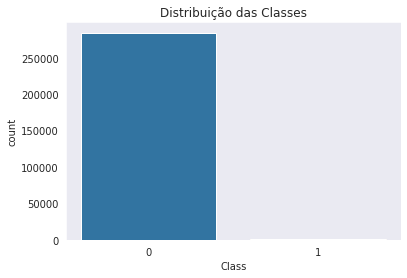

In [7]:
# Balanceamento das classes
print(df.Class.value_counts())
print("\nFraudes representam {:.4f}% do dataset.\n".format((df[df.Class == 1].shape[0] / df.shape[0]) * 100))

# Gráfico de barras para as Classes
fig, ax = plt.subplots()
sns.countplot('Class', data=df, ax=ax)
ax.set_title('Distribuição das Classes')
plt.plot()

Como infomado no inicio as transações fraudulentas represantam apenas 0,17% do total, e o gráfico de barras torna ainda mais nítida essa diferença. Assim é possivel se ter ideia de que para alimentar o modelo final de classificação será necessario um balanceamento prevido dos dados. 

Plotou-se também dois gráficos a fim de comparar as distribuições das 2 classes ao longo da dimensão tempo (Time). No entanto, não foi identificada nenhum informação a partir das distribuições de frequência abaixo.

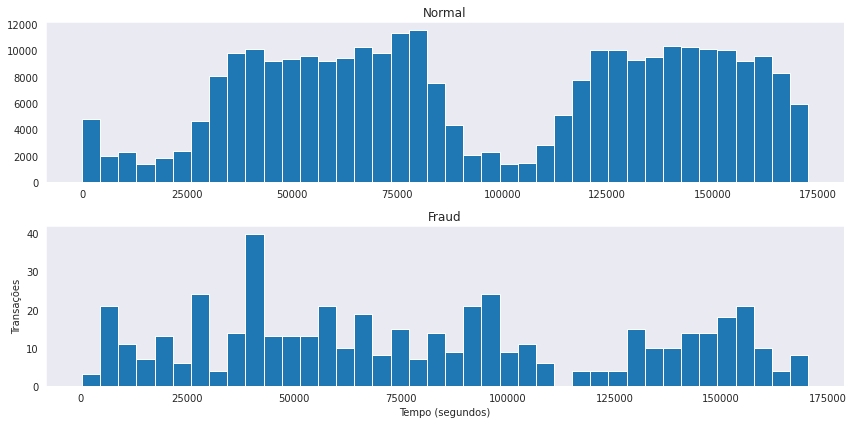

In [ ]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(12,6))

num_bins = 40

ax[0].hist(df.Time[df.Class == 0], bins=num_bins)
ax[0].set_title('Normal')

ax[1].hist(df.Time[df.Class == 1], bins=num_bins)
ax[1].set_title('Fraud')

plt.xlabel('Tempo (segundos)')
plt.ylabel('Transações')
plt.tight_layout()

Para ser possivel uma comparação mais direta entre `class = 0` e `class = 1` vamos plotar os gráficos das *features*.

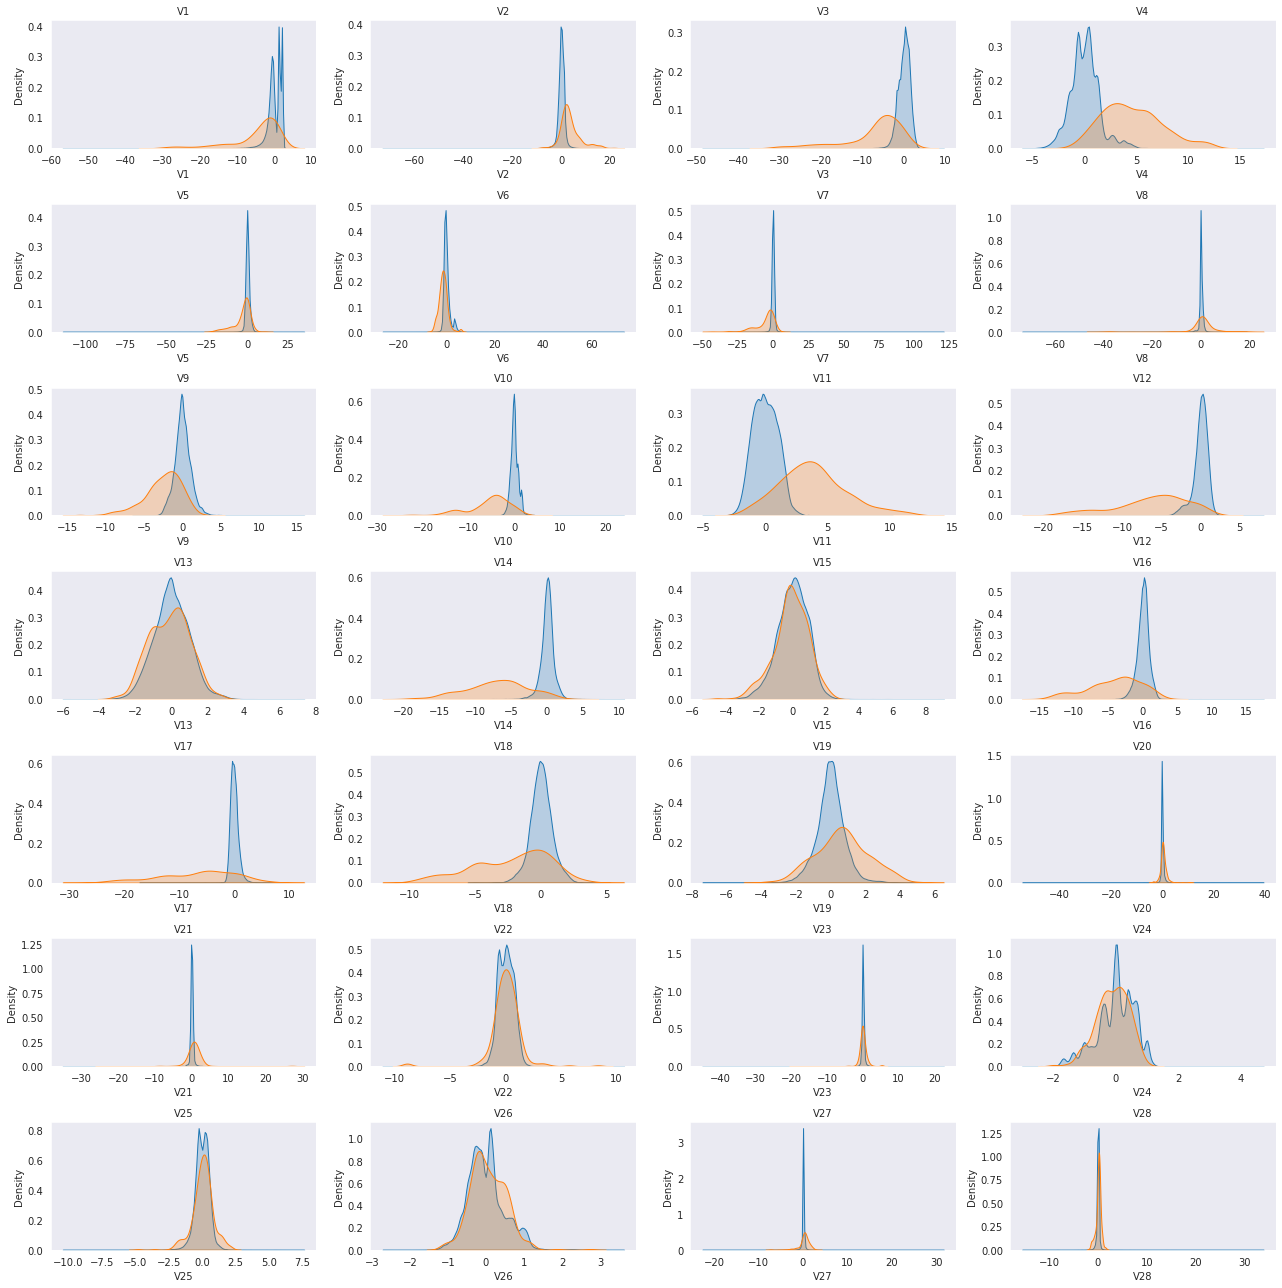

In [8]:
column_names = df.drop(['Class', 'Amount', 'Time'], axis=1).columns
num_plots = len(column_names)
df_class_0 = df[df.Class == 0]
df_class_1 = df[df.Class == 1]

fig, ax = plt.subplots(nrows=7, ncols=4, figsize=(18,18))
fig.subplots_adjust(hspace=1, wspace=1)

idx = 0
for col in column_names:
    idx += 1
    plt.subplot(7, 4, idx)
    sns.kdeplot(df_class_0[col], label="Class 0", shade=True)
    sns.kdeplot(df_class_1[col], label="Class 1", shade=True)
    plt.title(col, fontsize=10)
plt.tight_layout()

Observamos acima que as variáveis **V3**, **V4**, **V10** e **V11** têm comportamentos distitos o que pode caracterizar fraudes. Por outro lado **V8**, **V13** e **V15** apresentam-se muito similares.

# Insights

Com a ajuda desse breve analise exploratória extraímos que:
+ O dataset está muito desbalanceado, visto que, apenas 0,17% são de fato transações fraudulentas.
+ Não exitem valores ausentes.
+ As *features* originais foram padronizadas já que, a transformação PCA é sensível à escala de variáveis.
+ As colunas `Time` e `Amount` não estão normalizadas.

# Sobre o Método


O pricipal objetivo desse projeto é classificar entre transações licitas e transações fraudulentas, com isso ultilizaremos uma modelo de Regressão Logística. Para que nosso modelo tenha uma boa precisão faremos as seguintes preparações:

+ Padronizar as *features* `Time` e `Amount`;
+ Dividir entre treino e teste;
+ Balancear os dados a fim de evitar uma baixa performance para a classe 1 e *overfitting*.

### Padronizando `Time` e `Amount`

Como visto na fase exploratória `Amount` possui outliers, sendo assim ultilizaremos o método `StandardScaler`.

In [9]:
# padronizando as colunas Time e Amount
df_clean = df.copy()

std_scaler = StandardScaler()
df_clean['std_amount'] = std_scaler.fit_transform(df_clean['Amount'].values.reshape(-1, 1))
df_clean['std_time'] = std_scaler.fit_transform(df_clean['Time'].values.reshape(-1, 1))

df_clean.drop(['Time', 'Amount'], axis=1, inplace=True)

df_clean.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class,std_amount,std_time
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0,0.244964,-1.996583
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0,-0.342475,-1.996583
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0,1.160686,-1.996562
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0,0.140534,-1.996562
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0,-0.073403,-1.996541


### Dividir Treino e Teste.

Para garantir que o balanceamento esteja adequado, iremos "splitar" os dados já existentes entre treino e teste.

Para assegurar a proporcionalidade das classes, passaremos os argumentos `startify=y` e `shuffle=True`.

In [11]:
# separando variáveis entre X e y
X = df_clean.drop('Class', axis=1)
y = df['Class']

# dividindo o dataset entre treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, shuffle=True)

### Balanceamento dos dados

Usando a biblioteca `imblearn` é possível aplicar facilmente técnicas de balanceamento de dados. No caso, a opção neste projeto foi usar `Under-sampling`, preservando a classe minoritária.

In [12]:
#Under-sampling
rus = RandomUnderSampler()
X_rus, y_rus = rus.fit_sample(X_train, y_train)

A seguir iremos conferir se o balaceamento foi feito corretamente.

1    369
0    369
dtype: int64


[]

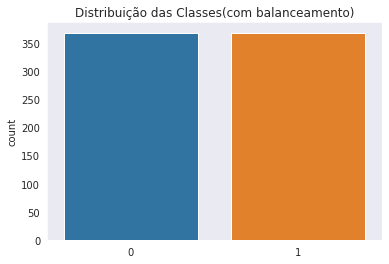

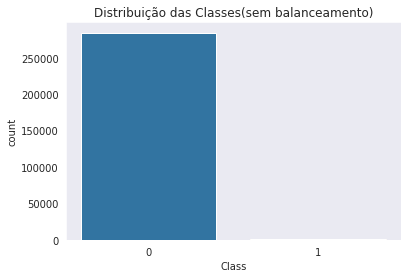

In [16]:
# ver o balanceamento das classes
print(pd.Series(y_rus).value_counts())

# plotar a nova distribuição de classes
fig, ax = plt.subplots()
sns.countplot(y_rus);
ax.set_title('Distribuição das Classes(com balanceamento)')

# Gráfico de barras para as Classes (sem balanceamento)
fig, ax = plt.subplots()
sns.countplot('Class', data=df, ax=ax)
ax.set_title('Distribuição das Classes(sem balanceamento)')
plt.plot()

### Matriz de correlação

Com os dados balanceados, podemos ver a matriz de correlação e identificar quais variáveis estão mais fortemente relacionadas com as outras.



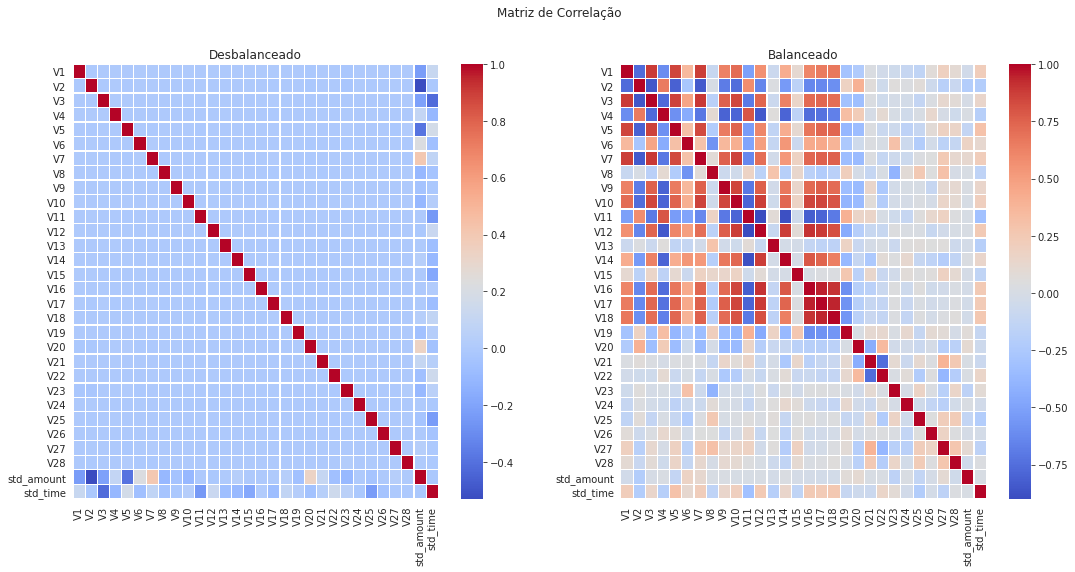

In [17]:
# Matriz de correlação
corr = X_train.corr()
corr_rus = pd.DataFrame(X_rus).corr()


fig, ax = plt.subplots(nrows=1, ncols=2, figsize = (18,8))
fig.suptitle('Matriz de Correlação')

sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns,
            linewidths=.1, cmap="coolwarm", ax=ax[0])
ax[0].set_title('Desbalanceado')

sns.heatmap(corr_rus, xticklabels=corr.columns, yticklabels=corr.columns,
            linewidths=.1, cmap="coolwarm", ax=ax[1])
ax[1].set_title('Balanceado')

plt.show()

Observe como anteriormente, sem o balanceamento de dados, a matriz de correlação não trazia nenhuma informação relevante. Entretanto, ela traz muito mais informações após um correto balanceamento.

# Modelo de Machine Learning

Com todos os dados preparados e após uma análise exploratória completa, podemos em fim construir um classificador usando a Regressão Logística.

Após instanciar o modelo, o mesmo será treinado em cima dos dados em `X_rus` e `y_rus`. Na sequência, serão realizadas as previsões sobre os dados de teste.

In [20]:
np.random.seed(3)
model = LogisticRegression()
model.fit(X_rus, y_rus)

y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)

# Avaliando Modelo

Com o modelo treinado e as previsões feitas, parte-se para a avaliação do desempenho. 

Por se tratar de um modelo de classificação o indicador *acurácia* pode por si só não representar bem a eficiencia do modelo, neste caso também o **AUC ROC** (onde se tem como melhor resultado possivel **1** e o pior possivel **0**)

Relatório de Classificação:
               precision    recall  f1-score   support

           0       1.00      0.96      0.98     71079
           1       0.04      0.90      0.07       123

    accuracy                           0.96     71202
   macro avg       0.52      0.93      0.53     71202
weighted avg       1.00      0.96      0.98     71202

Acurácia: 0.96

AUC: 0.93



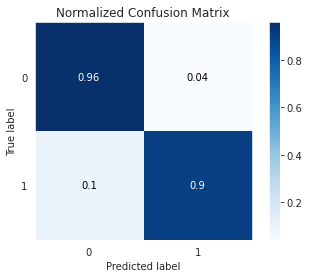

In [24]:
#matriz de confusão
skplt.metrics.plot_confusion_matrix(y_test, y_pred, normalize=True)

#relatório de classificação
print("Relatório de Classificação:\n", classification_report(y_test, y_pred, digits=2))

#acurácia do modelo
print("Acurácia: {:.2f}\n".format(accuracy_score(y_test, y_pred)))

#área sob da curva
print("AUC: {:.2f}\n".format(roc_auc_score(y_test, y_pred)))

Nosso modelo atingiu um **AUC** de 0,93 e *acurácia* de 0,96, podemos verificar a matriz de confunsão que para os verdadeiros positivos nosso modelo atingiu 0,9 ou seja em 90% dos casos ele ira acertar como transação fraudulenta 

# Conclusão



Mesmo com os dados bem tratados e limpos, sem valores ausentes ou variáveis categóricas, o desbalanceamento e a Transformação PCA dificultaram a analise e a construção do modelo, e apesar do bom resultado final é possivel otimizar os parâmetros para que se possa melhorar ainda mais o resultados, visto que por se tratar de transações com cartão de crédito, o alto volume diario destas pode gerar grandes prejuízos, dai a importancia de se ter um modelo de Machine learning com o máximo de precisão possível.